In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import numpy as np

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


## Loading some helper functions

In [2]:
from deepflow.mrst_coupling import load_production_data

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
import scipy.io as io
import os

def load_production_data(fname, name='ws_ref'):
    properties = ["bhp", "qOr", "qWr", "wcut", "qOs", "qWs"]
    wells = [0, 1]
    ws = io.loadmat(fname)

    well_props = []
    for well in wells:
        prop_temp = []
        for prop in properties:
            prop_series = np.array([t[0][0][well][prop] for t in ws[name]]).flatten()
            prop_temp.append(prop_series)
        well_props.append(prop_temp)

    return np.array(well_props)

## Load the reference case production data
This was output of MRST that was created manually in Matlab by storing the corresponding .mat files.
Here we are importing them again and loading the production data.

In [4]:
ref_fname = os.path.join("./mrst/mrst-2018a/modules/optimization/examples/model2Dtest/", "utils/vertcase3/ws_ref.mat")
ref_data = load_production_data(ref_fname, "ws_ref")

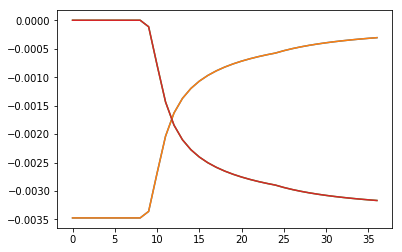

In [5]:
plt.plot(ref_data[1, 1, :])
plt.plot(ref_data[1, 4, :])
plt.plot(ref_data[1, 2, :])
plt.plot(ref_data[1, 5, :])

## Adding noise to the reference case pressure vs. time data

(100.0, 20000.0)

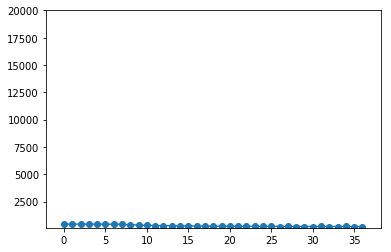

In [16]:
bhp_injector = ref_data[0, 0, :]
np.random.seed(42)
sigma_p = 5e-2*200e5
noise = np.random.normal(0, sigma_p, size=(len(bhp_injector)))
bhp_injector_noisy = bhp_injector+noise
fig, ax = plt.subplots(1, 1)
ax.plot(bhp_injector/1e5)
ax.scatter(range(len(bhp_injector_noisy)), bhp_injector_noisy/1e5)
ax.set_ylim(1e2, 2e4)

## Adding noise to the reference case water/oil rate vs. time data

0.00010416666666666667


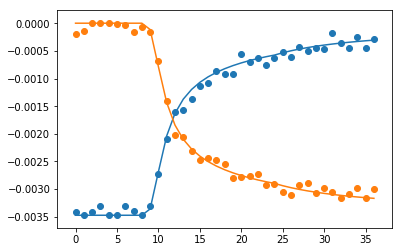

In [37]:
qo_producer = ref_data[1, 1, :]
qw_producer = ref_data[1, 2, :]
np.random.seed(42)
sigma_q = 0.03*300/(60*60*24)
print(sigma_q)
noise_o = np.random.normal(0, sigma_q, size=(len(qw_producer)))
noise_w = np.random.normal(0, sigma_q, size=(len(qw_producer)))
qo_producer_noisy = np.clip(qo_producer+noise_o, np.min(qo_producer), 0.0)
qw_producer_noisy = np.clip(qw_producer+noise_w, np.min(qw_producer), 0.0)
plt.plot(qo_producer)
plt.scatter(range(len(qo_producer_noisy)), qo_producer_noisy)

plt.plot(qw_producer)
plt.scatter(range(len(qw_producer_noisy)), qw_producer_noisy)

## Create a copy of the reference case and modify the variables to the noisy output

In [38]:
noise_ref = ref_data.copy()
noise_ref[0, 0, :] = bhp_injector_noisy
noise_ref[1, 1, :] = qo_producer_noisy
noise_ref[1, 2, :] = qw_producer_noisy

In [63]:
import scipy.io as io

def save_production_data(fname, noise_ref, name='ws_ref'):
    properties = ["bhp", "qOr", "qWr", "wcut", "qOs", "qWs"]
    wells = [0, 1]
    ws = io.loadmat(fname)
    for t, value in zip(ws[name], noise_ref[0, 0, :]):
        t[0][0][0]["bhp"] = np.array([[value]]).astype(float)

    for t, value in zip(ws[name], noise_ref[1, 1, :]):
        t[0][0][1]["qOr"] = np.array([[value]]).astype(float)
        
    for t, value in zip(ws[name], noise_ref[1, 2, :]):
        t[0][0][1]["qWr"] = np.array([[value]]).astype(float)

    for t, value in zip(ws[name], noise_ref[1, 1, :]):
        t[0][0][1]["qOs"] = np.array([[value]]).astype(float)
        
    for t, value in zip(ws[name], noise_ref[1, 2, :]):
        t[0][0][1]["qWs"] = np.array([[value]]).astype(float)
        
    io.savemat(fname, ws)
    return ws
    
ws_modified = save_production_data("./mrst/mrst-2018a/modules/optimization/examples/model2Dtest/utils/vertcase3_noise/ws_ref.mat", noise_ref)

## Sanity Check if stored values == generated noisy pressure data

37


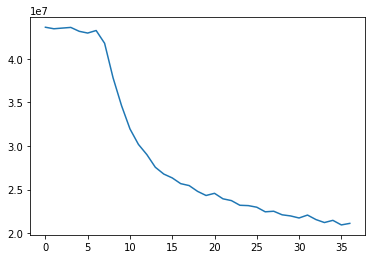

In [64]:
bhp_noise_recovered = np.array([t[0][0][0]["bhp"]  for t in ws_modified['ws_ref']]).flatten()
print(len(bhp_noise_recovered))
plt.plot(range(37), bhp_noise_recovered)

## Export to xarray storage format for the reference case

In [65]:
import xarray as xr

In [69]:
ds_ref = xr.open_dataset('./reference/reference_vertcase3.nc')
qor_ref = ds_ref['state_variables'][dict(state_variable=2, well=1)]
qwr_ref = ds_ref['state_variables'][dict(state_variable=1, well=1)]
p_ref = ds_ref['state_variables'][dict(state_variable=0, well=0)]
time = ds_ref.coords['time']
print(qor_ref)

<xarray.DataArray 'state_variables' (time: 37)>
array([-0.      , -0.      , -0.      , -0.      , -0.      , -0.      ,
       -0.      , -0.      , -0.      , -0.000114, -0.000787, -0.001435,
       -0.001843, -0.002099, -0.002274, -0.002403, -0.002503, -0.002583,
       -0.00265 , -0.002706, -0.002754, -0.002797, -0.002834, -0.002867,
       -0.002896, -0.002938, -0.002974, -0.003005, -0.003032, -0.003056,
       -0.003077, -0.003096, -0.003113, -0.003128, -0.003142, -0.003155,
       -0.003166])
Coordinates:
    well            <U8 'Producer'
    state_variable  <U10 'water-rate'
  * time            (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2020-08-23


In [71]:
#ref = np.load("./reference/prod_data_ref_noisy.npy")
#print(ref.shape)

(2, 4, 37)


In [72]:
ds_ref['state_variables'][dict(state_variable=2, well=1)] = ref[1, 2, :]#qor_ref = 
ds_ref['state_variables'][dict(state_variable=1, well=1)] = ref[1, 1, :]#qwr_ref = 
ds_ref['state_variables'][dict(state_variable=0, well=0)] = ref[0, 0, :]#p_ref =

In [73]:
#ds_ref.to_netcdf("./reference/reference_vertcase3_noise.nc")